In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image, ImageDraw
from ast import literal_eval
import matplotlib.pyplot as plt
import urllib
from tqdm.notebook import tqdm
import re

In [2]:
!git clone https://github.com/fizyr/keras-retinanet.git


Cloning into 'keras-retinanet'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 5736 (delta 12), reused 16 (delta 5), pack-reused 5705
Receiving objects: 100% (5736/5736), 13.37 MiB | 32.45 MiB/s, done.
Resolving deltas: 100% (3843/3843), done.


In [3]:
%cd keras-retinanet/

!pip install .

/kaggle/working/keras-retinanet
Processing /kaggle/working/keras-retinanet
     |████████████████████████████████| 51 kB 2.9 kB/s 
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp37-cp37m-linux_x86_64.whl size=173598 sha256=7fa0a3a539b05e32e518e8ec9b523b948e8f1ccc345269093e9fcc5ede6712d8
  Stored in directory: /root/.cache/pip/wheels/7f/ae/f4/f38a5a29bced2617252cb8aa726369b755c87eeef59fbba1d1
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=cbfaaf974d5b17dd39c74410a9c70f0364cee383fab0f2ea9e1bd0d93bd0f3db
  Stored in directory: /root/.cache/pip/wheels/a6/20/57/d7b7be8556e2ebf36345b3df4068a9a13bb90e4a2cc85a6994
Successfully built keras-retinanet keras-resnet
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
!python setup.py build_ext --inplace


running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.7/keras_retinanet/utils/compute_overlap.cpython-37m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [5]:
import tensorflow as tf
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

In [6]:
pwd

'/kaggle/working/keras-retinanet'

In [7]:
data_dir = '/kaggle/input/global-wheat-detection/'
train_path = data_dir + '/train/'
test_path = data_dir + '/test/'

In [8]:
os.listdir(data_dir)

['sample_submission.csv', 'test', 'train', 'train.csv']

In [9]:
train = pd.read_csv(data_dir+'train.csv')

In [10]:
train['image_id'][0]


'b6ab77fd7'

In [11]:
def append_ext(fn):
    return train_path + fn+ '.jpg'
train["image_id"]=train["image_id"].apply(append_ext)


In [12]:
train['bbox'].count()

147793

In [13]:
train['bbox'] = train['bbox'].apply(lambda x: x[1:-1].split(","))
train['xmin'] = train['bbox'].apply(lambda x: x[0]).astype('float32')
train['ymin'] = train['bbox'].apply(lambda x: x[1]).astype('float32')
train['width'] = train['bbox'].apply(lambda x: x[2]).astype('float32')
train['height'] = train['bbox'].apply(lambda x: x[3]).astype('float32')
train = train[['image_id','xmin', 'ymin', 'width', 'height']]
train["xmax"] = train.apply(lambda col: col.xmin + col.width, axis=1)
train["ymax"] = train.apply(lambda col: col.ymin + col.height, axis = 1)
train.head()

image_id   xmin   ymin  width  \
0  /kaggle/input/global-wheat-detection//train/b6...  834.0  222.0   56.0   
1  /kaggle/input/global-wheat-detection//train/b6...  226.0  548.0  130.0   
2  /kaggle/input/global-wheat-detection//train/b6...  377.0  504.0   74.0   
3  /kaggle/input/global-wheat-detection//train/b6...  834.0   95.0  109.0   
4  /kaggle/input/global-wheat-detection//train/b6...   26.0  144.0  124.0   

   height   xmax   ymax  
0    36.0  890.0  258.0  
1    58.0  356.0  606.0  
2   160.0  451.0  664.0  
3   107.0  943.0  202.0  
4   117.0  150.0  261.0

In [14]:
def to_int(x):
    a = x[0]
    a = int(a)
    return a
    

In [15]:
train['xmin'] = train[['xmin']].apply(to_int, axis=1)

In [16]:
train['ymin'] = train[['ymin']].apply(to_int, axis=1)

In [17]:
train['xmax'] = train[['xmax']].apply(to_int, axis=1)

In [18]:
train['ymax'] = train[['ymax']].apply(to_int, axis=1)

In [19]:
train.drop('height', axis =1, inplace=True)

In [20]:
train.drop('width', axis =1, inplace=True)

In [21]:
train.head()

image_id  xmin  ymin  xmax  ymax
0  /kaggle/input/global-wheat-detection//train/b6...   834   222   890   258
1  /kaggle/input/global-wheat-detection//train/b6...   226   548   356   606
2  /kaggle/input/global-wheat-detection//train/b6...   377   504   451   664
3  /kaggle/input/global-wheat-detection//train/b6...   834    95   943   202
4  /kaggle/input/global-wheat-detection//train/b6...    26   144   150   261

In [22]:
train['class'] = 'wheat'

In [23]:
from sklearn.model_selection import train_test_split


In [24]:
train_df, test_df = train_test_split(train, test_size=0.2, random_state=42)

In [25]:
train_df

image_id  xmin  ymin  xmax  \
9998    /kaggle/input/global-wheat-detection//train/ab...   494   974   589   
41363   /kaggle/input/global-wheat-detection//train/20...   868   891   960   
10825   /kaggle/input/global-wheat-detection//train/e9...   634   499   698   
108600  /kaggle/input/global-wheat-detection//train/57...   238    69   312   
122653  /kaggle/input/global-wheat-detection//train/2f...     0   831    40   
...                                                   ...   ...   ...   ...   
119879  /kaggle/input/global-wheat-detection//train/e6...   468   250   565   
103694  /kaggle/input/global-wheat-detection//train/40...   170   601   217   
131932  /kaggle/input/global-wheat-detection//train/c3...   488   955   559   
146867  /kaggle/input/global-wheat-detection//train/8b...   916   471  1024   
121958  /kaggle/input/global-wheat-detection//train/70...   842   944   983   

        ymax  class  
9998    1024  wheat  
41363   1024  wheat  
10825    559  wheat  
108600   174  wheat  
122653   944  wheat  
...      ...    ...  
119879   327  wheat  
103694   643  wheat  
131932  1024  wheat  
146867   552  wheat  
121958  1024  wheat  

[118234 rows x 6 columns]

In [26]:
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

In [27]:
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [28]:
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)

In [29]:
train_path

'/kaggle/input/global-wheat-detection//train/'

In [30]:
classes = set(['wheat'])

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(sorted(classes)):
    f.write('{},{}\n'.format(line,i))

In [31]:
!head classes.csv


wheat,0


In [32]:
!head annotations.csv


/kaggle/input/global-wheat-detection//train/ab026459d.jpg,494,974,589,1024,wheat
/kaggle/input/global-wheat-detection//train/20a86a215.jpg,868,891,960,1024,wheat
/kaggle/input/global-wheat-detection//train/e9d060d22.jpg,634,499,698,559,wheat
/kaggle/input/global-wheat-detection//train/57587eaf7.jpg,238,69,312,174,wheat
/kaggle/input/global-wheat-detection//train/2ff4e8bb0.jpg,0,831,40,944,wheat
/kaggle/input/global-wheat-detection//train/8fb3138d9.jpg,271,103,348,167,wheat
/kaggle/input/global-wheat-detection//train/61dcbea57.jpg,637,182,693,268,wheat
/kaggle/input/global-wheat-detection//train/f04d9c252.jpg,165,500,309,558,wheat
/kaggle/input/global-wheat-detection//train/96b19d664.jpg,162,761,238,862,wheat
/kaggle/input/global-wheat-detection//train/6b4169a72.jpg,956,781,1014,838,wheat


In [33]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_oid_v1.0.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [34]:
EPOCHS = 3
BATCH_SIZE=8
STEPS = 100 #len(train_df)//BATCH_SIZE #Keeping it small for faster commit
LR=1e-3

In [35]:
!keras_retinanet/bin/train.py --random-transform --weights {PRETRAINED_MODEL} --lr {LR} --batch-size {BATCH_SIZE} --steps {STEPS} --epochs {EPOCHS} --no-resize csv annotations.csv classes.csv

Using TensorFlow backend.
2020-05-28 07:38:30.807752: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-05-28 07:38:38.454999: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-28 07:38:38.780328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-05-28 07:38:38.781052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2020-05-28 07:38:38.781126: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart

In [36]:
!ls snapshots


_pretrained_model.h5  resnet50_csv_02.h5
resnet50_csv_01.h5    resnet50_csv_03.h5


In [37]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])


In [38]:

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

Using TensorFlow backend.


tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [-50.796833, -50.796833,  50.7

In [39]:
li=os.listdir(test_path)
li[:5]

['796707dd7.jpg',
 'cc3532ff6.jpg',
 '51f1be19e.jpg',
 '51b3e36ab.jpg',
 'f5a1f0358.jpg']

In [40]:
def predict(image):
    image = preprocess_image(image.copy())
    #image, scale = resize_image(image)

    boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(image, axis=0)
  )

    #boxes /= scale

    return boxes, scores, labels

In [41]:
THRES_SCORE = 0.4

def draw_detections(image, boxes, scores, labels):
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < THRES_SCORE:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(image, b, color=color)

        caption = "{:.3f}".format(score)
        draw_caption(image, b, caption)

In [42]:
def show_detected_objects(image_name, boxes, scores, labels):
    img_path = test_path+'/'+image_name
  
    image = read_image_bgr(img_path)
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    draw_detections(draw, boxes, scores, labels)
    plt.figure(figsize=(15,10))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

In [43]:
samsub=pd.read_csv("/kaggle/input/global-wheat-detection/sample_submission.csv")
imgs = samsub['image_id'].values

In [44]:
import tensorflow as tf
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

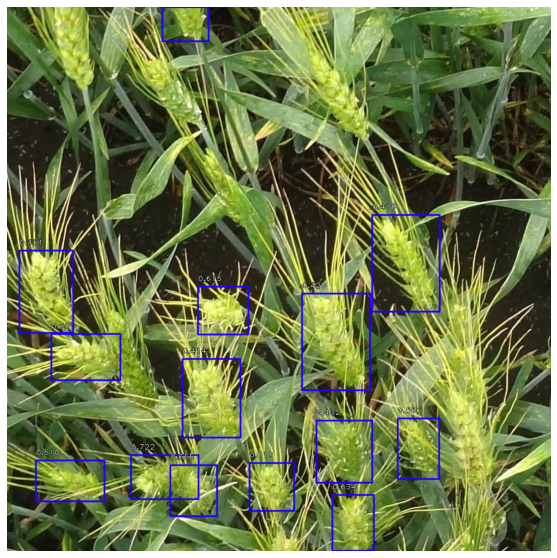

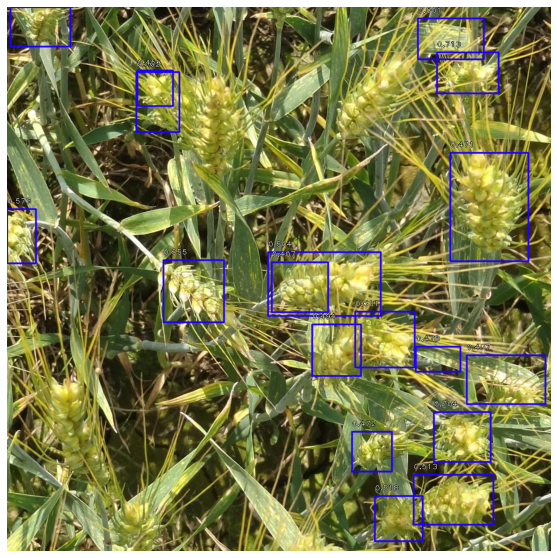

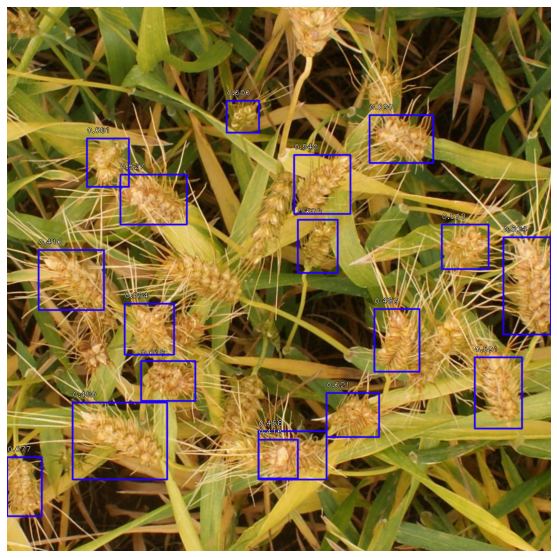

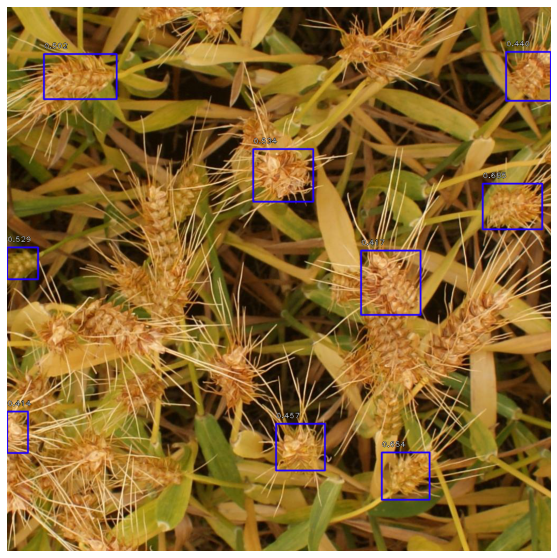

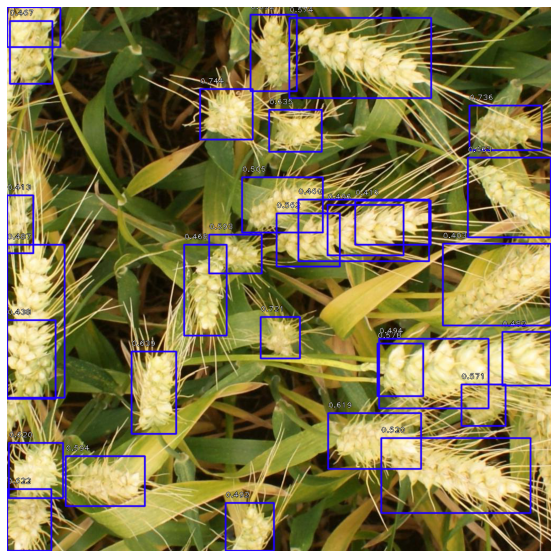

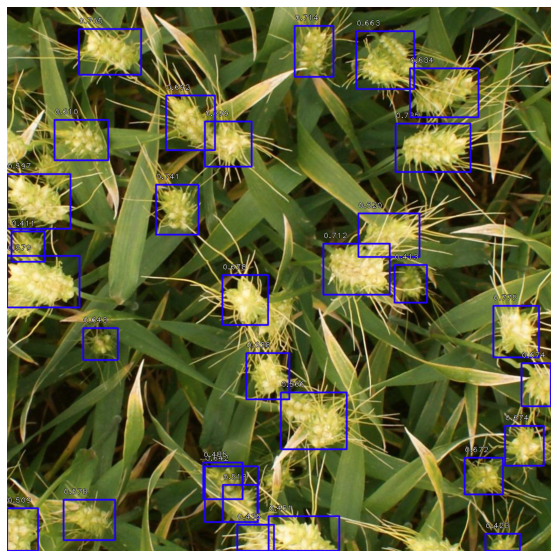

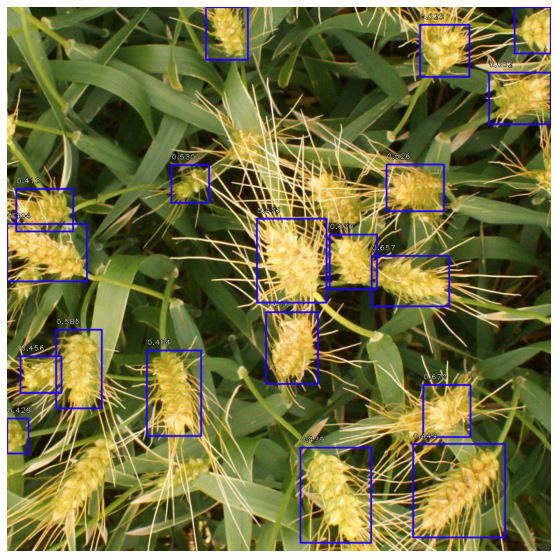

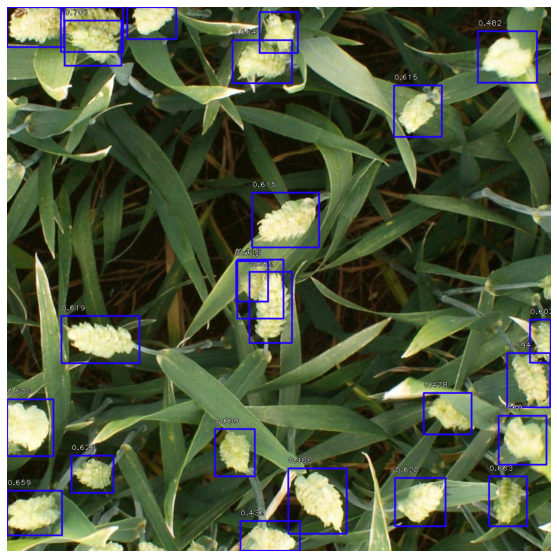

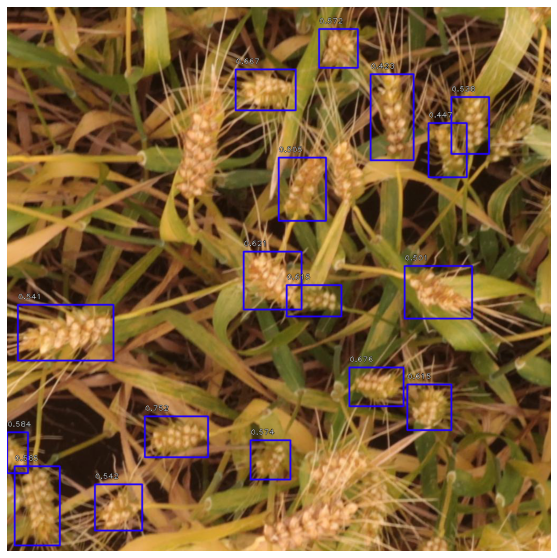

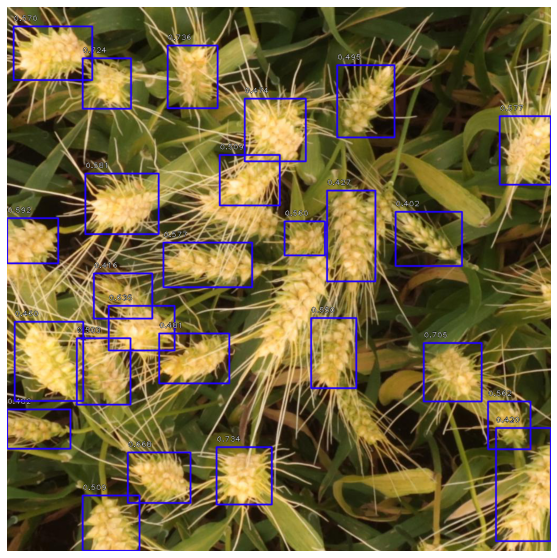

In [45]:
pred_string=[]
for img in imgs:
    preds=''
    img_name=img+'.jpg'
    img_path = test_path+'/'+img_name
    image = read_image_bgr(img_path)
    boxes, scores, labels = predict(image)
    show_detected_objects(img_name, boxes, scores, labels)
    boxes=boxes[0]
    scores=scores[0]
    for idx in range(boxes.shape[0]):
        if scores[idx]>THRES_SCORE:
            box,score=boxes[idx],scores[idx]
            preds+="{:0.2f} {} {} {} {} ".format(score, int(box[0]), int(box[1]), int(box[2]-box[0]), int(box[3]-box[1]))
    pred_string.append(preds)

In [46]:
sub={"image_id":imgs, "PredictionString":pred_string}
sub=pd.DataFrame(sub)
sub.head(10)

image_id                                   PredictionString
0  aac893a91  0.72 233 843 126 82 0.66 735 774 77 114 0.63 6...
1  51f1be19e  0.71 809 85 116 77 0.70 803 762 106 93 0.67 6 ...
2  f5a1f0358  0.69 682 203 119 89 0.68 150 247 79 91 0.68 0 ...
3  796707dd7  0.68 895 332 112 86 0.65 705 838 89 88 0.53 46...
4  51b3e36ab  0.74 363 154 98 95 0.74 870 185 136 84 0.72 47...
5  348a992bb  0.77 915 562 85 96 0.74 280 334 79 93 0.73 731...
6  cc3532ff6  0.78 374 0 78 99 0.67 607 428 89 103 0.67 783 ...
7  2fd875eaa  0.71 108 25 106 84 0.69 0 0 107 75 0.68 226 0 ...
8  cb8d261a3  0.75 259 770 118 77 0.68 644 678 102 72 0.67 4...
9  53f253011  0.74 302 72 93 118 0.73 394 828 104 108 0.72 1...